# Econophysics
## Assignment #2: Statistical analysis of an asset
## ETHUSD

In [283]:
# Date parsing libs
import datetime as dt
import calendar
# Numerical libs
import numpy as np
# Linear regression
from scipy import stats
# Kernel Density Estimation lib
from sklearn.neighbors import KernelDensity
# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as pltdates
%matplotlib inline

# Data parsing
The data used is provided by the website _coinmarketcap.com_

Dataset size =  958


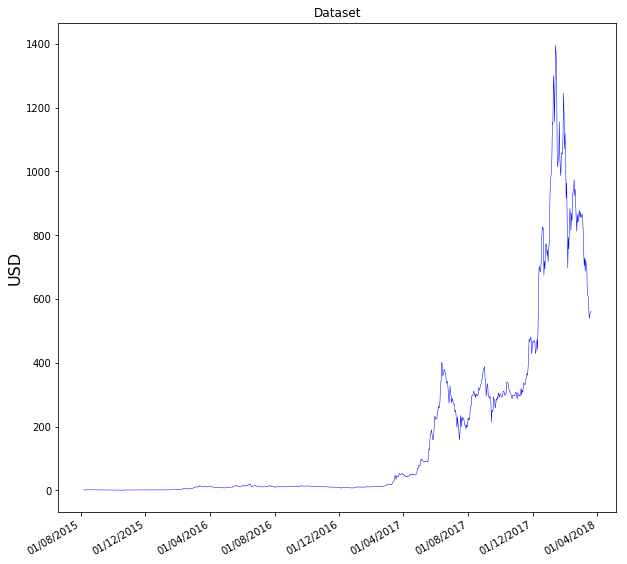

In [284]:
# Open data file
data_file = open('eth.dat', 'r')

# Data arrays
price_date = []
open_price = np.array([])
high_price = np.array([])
low_price = np.array([])
close_price = np.array([])
volume = np.array([])
m_cap = np.array([])

# Read data file line by line
for line in data_file:
    if not line.startswith('#'): # Skip comments
        row = line.split()
        # Date parsing 
        month = list(calendar.month_abbr).index(row[0])
        price_date.insert(0, dt.date(int(row[2]), month, int(row[1])))
        # Data parsing
        open_price = np.insert(open_price, 0, float(row[3]), axis=0)
        high_price = np.insert(high_price, 0, float(row[4]), axis=0)
        low_price = np.insert(low_price, 0, float(row[5]), axis=0)
        close_price = np.insert(close_price, 0, float(row[6]), axis=0)
        volume = np.insert(volume, 0, float(row[7]), axis=0)
        m_cap = np.insert(m_cap, 0, float(row[8]), axis=0)

# Dataset size
data_size = close_price.size
print ('Dataset size = ', data_size)

# Plot dataset
plt.figure(figsize=(10,10))
plt.title('Dataset')
plt.ylabel('USD', fontsize=16)
plt.gca().xaxis.set_major_formatter(pltdates.DateFormatter('%d/%m/%Y'))
#plt.gca().xaxis.set_major_locator(pltdates.DayLocator())
plt.plot(price_date, close_price, 'b', linewidth=0.5)
plt.gcf().autofmt_xdate()
plt.show()

# Defining the return
Return on a given date $r_n$ is defined as following:

\begin{align}
r_n &= \frac{x_n - x_{n-1}}{x_{n-1}} \\
    &= \frac{x_n}{x_{n-1}} - 1
\end{align}

where the $x_n$ are the closing prices of the asset.

If we take the logarithm of the return and use the fist order approximation $\ln{y} \approx y-1$ we obtain

\begin{align}
r_n &= \frac{x_n}{x_{n-1}} - 1         \\
    &\approx \ln{\frac{x_n}{x_{n-1}}} = \ln{x_n} - \ln{n_{n-1}}
\end{align}

yielding

$$r_n \approx \ln{x_n} - \ln{n_{n-1}}$$


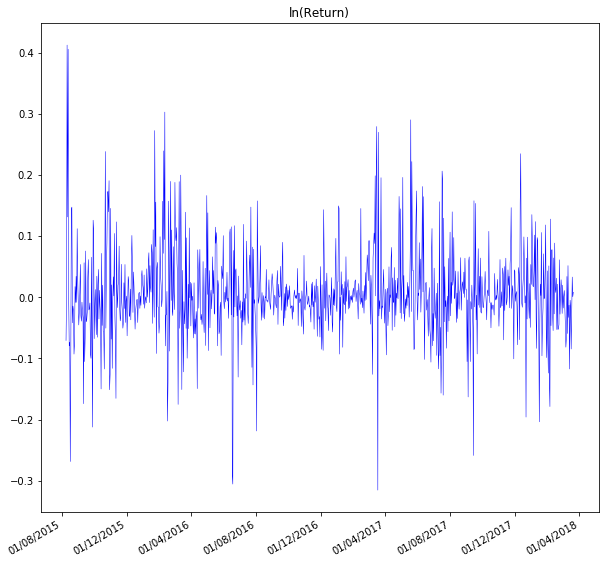

In [285]:
# Define return
r = np.log(close_price) - np.log(np.roll(close_price, 1))
r = np.delete(r, [0,1])
price_date = np.delete(price_date, [0,1])

# Plot return
plt.figure(figsize=(10,10))
plt.title('ln(Return)')
plt.gca().xaxis.set_major_formatter(pltdates.DateFormatter('%d/%m/%Y'))
plt.plot(price_date, r, 'b', linewidth=0.5)
plt.gcf().autofmt_xdate()
plt.show()

# Power pectral density of the random signal

Assuming the value of the return is given by a stationary process, we can calculate its amplitude spectral density which is equal to its truncated Fourier transform.

$$\widetilde{r}(\omega) = \mathscr{F}[t(t)](\omega) =\frac{1}{\sqrt{T}}\int_{[0,T]} dt e^{-i\omega t} r(t)$$

To actually calculate this value using our discrete dataset we'll use the Fast Fourier Transform algorithm and a Hanning window.

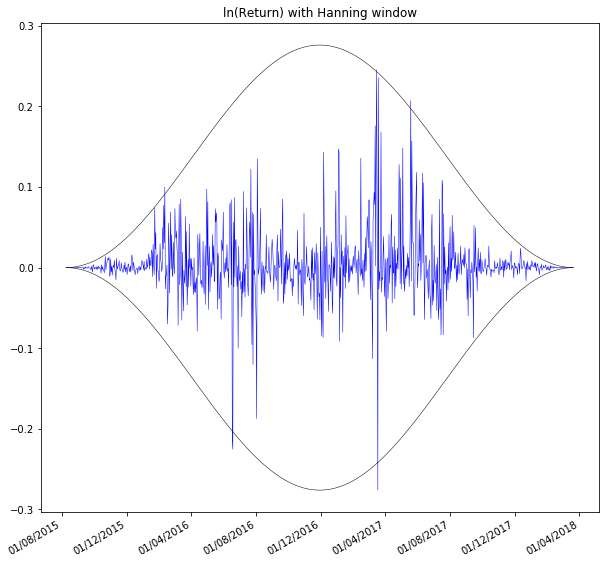

In [286]:
# Apply Hanning window
hann = np.hanning(np.size(r))
r_hann = hann*r
hann = hann*np.max(np.abs(r_hann))
# Plot
plt.figure(figsize=(10,10))

plt.title('ln(Return) with Hanning window')
plt.gca().xaxis.set_major_formatter(pltdates.DateFormatter('%d/%m/%Y'))
plt.gcf().autofmt_xdate()

plt.plot(price_date, r_hann, 'b', linewidth=0.5)
plt.plot(price_date, hann, 'k', linewidth=0.5)
plt.plot(price_date, -hann, 'k', linewidth=0.5)

plt.show()

## PSD calculation

The actual power spectral density is

$$S(\omega) = |\widetilde{r}(\omega)|^2$$

Here we both calculate the FFT (in red) and use the built-in function provided by _matplotlib_ to obtain the value of the PSD in $dB/Hz$ (in blue) to compare the results.

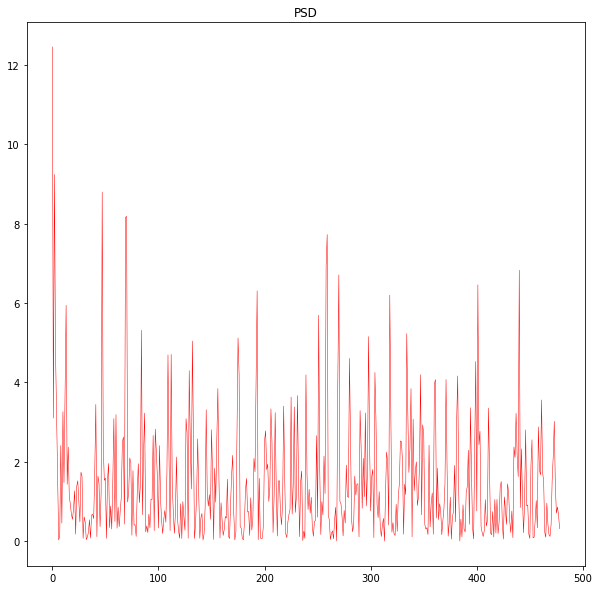

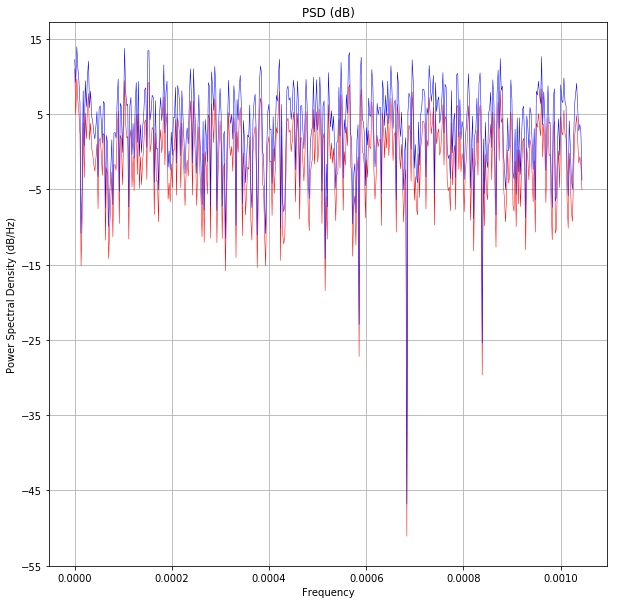

In [287]:
# FFT (with Hanning window)
r_fft = np.fft.fft(r_hann)
S_r = np.real(r_fft * r_fft.conjugate())

# Plot (Power Spectral Density)
plt.figure(figsize=(10,10))
plt.title('PSD')
#plt.ylim((0, 1.1*np.max(S_r)))
plt.plot(S_r[:int(data_size/2)], 'r', linewidth=0.5)
plt.show()

# Plot Power Spectral Density
plt.figure(figsize=(10,10))
plt.title('PSD (dB)')
x_plot = np.linspace(0, 1/data_size, int(data_size/2))
y_dB = 10*np.log10(S_r[:int(data_size/2)])
plt.plot(x_plot, y_dB, 'r', linewidth=0.5)
plt.psd(r, NFFT=np.size(r), Fs=2/data_size, linewidth=0.5, color='b') # Default window is Hanning
plt.show()

# Autocorrelation

Once we have Power Spectral Density the Autocorrelation function is easily calculated using the Wiener-Khinchin theorem.

The Autocorrelation function is simply the Inverse Fourier Transform of the Power Spectral Density.

$$A(\tau) = \mathscr{F}^{-1}[S(\omega)](\tau)$$

The result is an almost zero autocorrelation for intervals $\tau \neq 0$ which means that the values of the return for at two different times are completely unrelated. This result is predicted by the efficient market hypothesis.

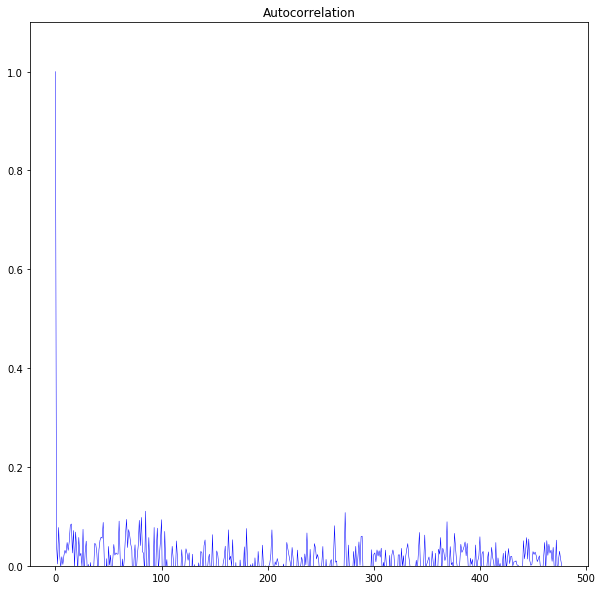

In [288]:
# IFFT (Autocorrelation)
A = np.real(np.fft.ifft(S_r))
A = (1/np.max(A)) * A
# Plot
plt.figure(figsize=(10,10))
plt.title('Autocorrelation')
plt.ylim((0, 1.1*np.max(A)))
plt.plot(A[:int(data_size/2)], 'b', linewidth=0.5)
plt.show()

The same calculation is performed but this time using the square of the returns.

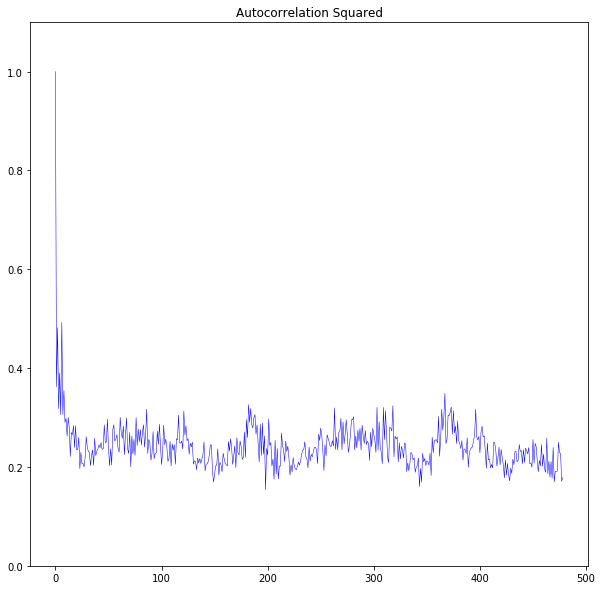

In [289]:
# Volatility Clusters
r_sq = np.square(r)
r_sq_fft = np.real(np.fft.fft(r_sq))
A_sq = np.real(np.fft.ifft(r_sq_fft * np.conj(r_sq_fft)))
A_sq = (1/np.max(A_sq)) * A_sq
# Plot
plt.figure(figsize=(10,10))
plt.title('Autocorrelation Squared')
plt.ylim((0, 1.1*np.max(A_sq)))
plt.plot(A_sq[:int(data_size/2)], 'b', linewidth=0.5)
plt.show()

# Kernel Density Estimation

We are interested in calculating the probability density function of the return.

AttributeError: 'function' object has no attribute 'xaxis'

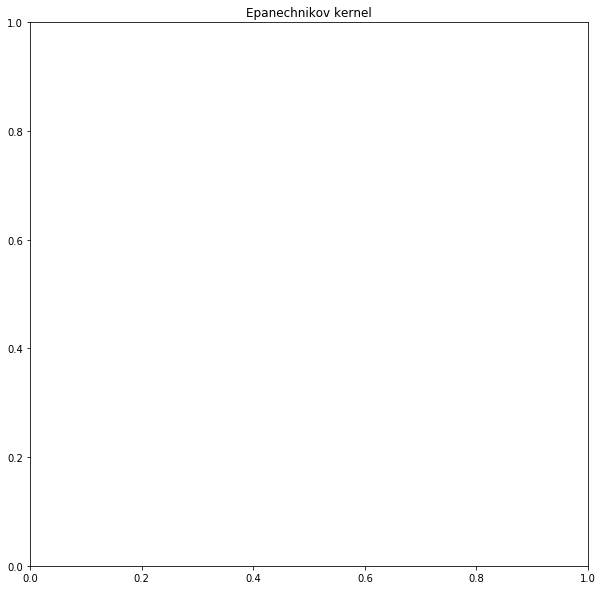

In [290]:
# Plot Epanechnikov kernel
def format_func(x, loc):
    if x == 0:
        return '0'
    elif x == 1:
        return 'h'
    elif x == -1:
        return '-h'
    else:
        return '%ih' % x

plt.figure(figsize=(10,10))
plt.title('Epanechnikov kernel')
plt.axis.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
plt.axis.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.axis.yaxis.set_major_locator(plt.NullLocator())
x_plot = np.linspace(-2,2,1000)
y_epa = np.exp(KernelDensity(kernel='epanechnikov').fit(np.zeros((1,1))).score_samples(x_plot[:,np.newaxis]))
plt.xlim((-1.1,1.1))
plt.ylim((0, 1.1*np.max(y_epa)))
plt.fill(x_plot, y_epa, fc='#AAAAFF', linewidth=0.5)
plt.show()

# Histogram
print('Histogram:')
nbins = 50
print('number of bins = {}'.format(nbins))
plt.figure(figsize=(10,10))
plt.hist(r, bins=nbins, density=True)

# Kernel Density Estimation
print('Kernel Density Estimation (Epanechnikov)')
x_plot = np.linspace(np.min(r), np.max(r), 1000)
bw = (x_plot[-1] - x_plot[0])/nbins
print('bandwidth = {}'.format(bw))
kde = KernelDensity(kernel='epanechnikov', bandwidth=bw).fit(r[:,np.newaxis])
plt.title('KDE Epanechnikov')
plt.xlabel('ln(return)')
plt.ylabel('P(return)')
Plog = kde.score_samples(x_plot[:,np.newaxis])
plt.plot(x_plot, np.exp(Plog), 'r', linewidth=0.5)
plt.show()